# Deep Convolutional Neural Network for Art Classification with PyTorch
# Part 4: CNN

## Imports

In [1]:
# pip install --upgrade torch torchvision

In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import PIL
from PIL import Image
import cv2
import pathlib
import glob
from pathlib import Path
import numpy as np
import shutil
import random
import pandas as pd
import argparse
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from platform import python_version
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("Python Version: ",python_version())

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Python Version:  3.6.13


In [4]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
project_name='CNN_classifier'

## Data Exploration

In [7]:
def remove_folder(dir_path):
    for i in range(len(os.listdir(dir_path))):
        if os.listdir(dir_path)[i] == ' .ipynb_checkpoints':
            shutil.rmtree(os.path.join(dir_path,' .ipynb_checkpoints'))
        else: 
            pass

In [8]:
# strating with blank resized images
data_dir = os.path.join('wikiart_binary')

print(os.listdir(data_dir))

classes = os.listdir(data_dir + "/train")
remove_folder(os.path.join(data_dir,'train'))
remove_folder(os.path.join(data_dir,'test'))
# shutil.rmtree(os.path.join(data_dir,'train','.ipynb_checkpoints'))
# shutil.rmtree(os.path.join(data_dir,'test','.ipynb_checkpoints'))

print(classes)

['.ipynb_checkpoints', 'test', 'train']
['pre_1910s', 'post_1910s']


In [9]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())


In [10]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.9725, 0.9686, 0.9647,  ..., 1.0000, 0.9647, 0.9725],
         [0.9686, 0.9725, 0.9686,  ..., 1.0000, 0.9686, 0.9765],
         [0.9686, 0.9647, 0.9647,  ..., 1.0000, 0.9686, 0.9725],
         ...,
         [0.9843, 0.9843, 0.9804,  ..., 0.0118, 1.0000, 0.9647],
         [0.9843, 0.9843, 0.9804,  ..., 0.0471, 1.0000, 0.9686],
         [0.9843, 0.9843, 0.9804,  ..., 0.0275, 1.0000, 0.9961]],

        [[0.9686, 0.9686, 0.9725,  ..., 0.9961, 0.9647, 0.9725],
         [0.9686, 0.9725, 0.9686,  ..., 0.9961, 0.9686, 0.9765],
         [0.9686, 0.9647, 0.9647,  ..., 1.0000, 0.9686, 0.9725],
         ...,
         [0.9843, 0.9843, 0.9804,  ..., 0.0078, 1.0000, 0.9647],
         [0.9843, 0.9843, 0.9804,  ..., 0.0314, 1.0000, 0.9686],
         [0.9843, 0.9843, 0.9804,  ..., 0.0118, 1.0000, 1.0000]],

        [[0.9608, 0.9608, 0.9608,  ..., 0.9804, 0.9569, 0.9647],
         [0.9608, 0.9647, 0.9608,  ..., 0.9804, 0.9608, 0.9686],
         [0.9608, 0.9569, 0.9569,  ..., 0.9843, 0.9608, 0.

In [11]:

print(dataset.classes)

['post_1910s', 'pre_1910s']


In [12]:
len(dataset.classes)


2

In [13]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [14]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  post_1910s (0)


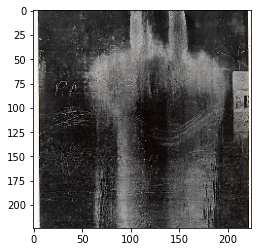

In [15]:
show_example(*dataset[0])

Label:  post_1910s (0)


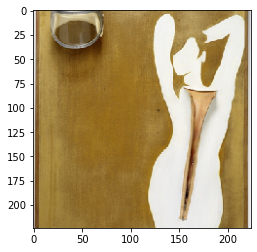

In [16]:
show_example(*dataset[3250])

## Training and Validation datasets

In [54]:
random_seed = 42
torch.manual_seed(random_seed);

In [55]:
val_size = 500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(37129, 500)

In [19]:
from torch.utils.data.dataloader import DataLoader

batch_size= 16

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [56]:
show_batch(train_dl)

NameError: name 'show_batch' is not defined

# Defining the Convolutional Neural Network n°1

In [23]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [26]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([16, 3, 224, 224])
out.shape: torch.Size([16, 8, 112, 112])


In [27]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
class Wikiart(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(262144, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 22))
        
    def forward(self, xb):
        return self.network(xb) 
    

In [29]:
model = Wikiart()
model

Wikiart(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=262144, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

In [31]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

In [32]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [35]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        torch.save(model.state_dict(), 'wikiart-cnn.pth')
        history.append(result)
    return history

# Defining the Convolutional Neural Network n°2

In [17]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "wikiart_binary"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, efficientnet, wide_resnet, regnet]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
#                         outputs, aux_outputs = model(inputs.float())
#                         loss1 = criterion(outputs, labels.unsqueeze(1))
#                         loss2 = criterion(aux_outputs, labels.unsqueeze(1))
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
#                         outputs = model(inputs.float())
                        loss = criterion(outputs, labels)
#                         loss = criterion(outputs, labels.unsqueeze(1))

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history

In [19]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [20]:
# !pip install efficientnet_pytorch

In [21]:
# from efficientnet_pytorch import EfficientNet

In [22]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "wide_resnet":
        """ Wide Resnet50 2
        """
        model_ft = models.wide_resnet50_2(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "regnet":
        """ Regnet y16gf
        """
        model_ft = models.regnet_y_16gf(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "resnext":
        """ Resnext 50
        """
        model_ft = models.resnext50_32x4d(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "vit":
        """ vit l16
        """
        model_ft = models.vit_l_16(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "efficientnet":
        """ Efficientnet
        """
#         model_ft = EfficientNet.from_name('efficientnet-b5')
#         for param in model_ft.parameters():
#             param.requires_grad = True
#         num_ftrs = model_ft._fc.in_features
#         model_ft._fc = nn.Linear(num_ftrs, 1)
        model_ft = models.efficientnet_b5(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
#         num_ftrs = model_ft.classifier.in_features
#         model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [25]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized (maybe try Adam)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(params_to_update, lr=0.0005)



Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# Setup the loss fxn for multi-class
criterion = nn.CrossEntropyLoss()

# Setup the loss fxn for binary
# criterion = nn.BCELoss()
# target = Variable(torch.LongTensor(batch_size).random_(0, num_classes))
# criterion = nn.BCEWithLogitsLoss()

# loss = nn.BCELoss()
# target = Variable(torch.LongTensor(batch_size).random_(0, num_classes))
# print(target)
# criterion = loss(last_out.long(), target)

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 0.4210 Acc: 0.8158
test Loss: 0.3629 Acc: 0.8469

Epoch 1/49
----------
train Loss: 0.4129 Acc: 0.8175
test Loss: 0.3511 Acc: 0.8494

Epoch 2/49
----------
train Loss: 0.4097 Acc: 0.8202
test Loss: 0.3752 Acc: 0.8394

Epoch 3/49
----------
train Loss: 0.4081 Acc: 0.8197
test Loss: 0.3587 Acc: 0.8480

Epoch 4/49
----------
train Loss: 0.4040 Acc: 0.8243
test Loss: 0.4161 Acc: 0.8346

Epoch 5/49
----------
train Loss: 0.4007 Acc: 0.8261
test Loss: 0.3413 Acc: 0.8553

Epoch 6/49
----------
train Loss: 0.4011 Acc: 0.8259
test Loss: 0.4431 Acc: 0.8067

Epoch 7/49
----------
train Loss: 0.4004 Acc: 0.8264
test Loss: 0.4883 Acc: 0.7859

Epoch 8/49
----------
train Loss: 0.3977 Acc: 0.8290
test Loss: 0.3672 Acc: 0.8506

Epoch 9/49
----------
train Loss: 0.3933 Acc: 0.8281
test Loss: 0.3375 Acc: 0.8590

Epoch 10/49
----------
train Loss: 0.3992 Acc: 0.8279
test Loss: 0.3333 Acc: 0.8581

Epoch 11/49
----------
train Loss: 0.3961 Acc: 0.8257
test Loss: 0.3387 Acc

### need to do a loop so if the output is post --> re run for post otherwise re run for pre 

In [ ]:
torch.save(model_ft.state_dict(), "wikiart-cropped-post-wideresnet50-50epochs.pth")


In [ ]:
# model = models.vgg11_bn(pretrained=True)
# model = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft.load_state_dict(torch.load('wikiart-cropped-binary.pth'))

In [ ]:
import torch, torchvision.models
model = torchvision.models.vgg11_bn()
path = 'wikiart-cropped-pre.pth'

In [ ]:
torch.save(model.state_dict(), path) # nothing else here
model.load_state_dict(torch.load(path))

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.Adam(scratch_model.parameters(), lr=0.001)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
hist


# Run the model n°1

In [ ]:
model = to_device(Wikiart(), device)

In [ ]:
evaluate(model, val_dl)

In [ ]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)



In [ ]:
model = Wikiart(*args, **kwargs)
model.load_state_dict(torch.load('wikiart-cnn.pth'))
model.eval()

# Plots and verifications

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(hist)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
data_dir

In [ ]:
import torch

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
#     xb = torch.from_numpy(img).to(DEVICE).unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]


In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ft))


In [ ]:
img, label = test_dataset[10500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ft))



In [ ]:
img, label = test_dataset[148]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ft))


In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
torch.save(model.state_dict(), 'wikiart-cnn.pth')



In [ ]:
model2 = to_device(Wikiart(), device)



# Import model n°2

In [ ]:
# model_binary = Net()
# model_binary.load_state_dict(torch.load("wikiart-cropped-binary.pth"))
model_binary = torch.load_state_dict("wikiart-cropped-binary.pth")
model_binary.eval()

In [ ]:
model_ft = torch.load("wikiart-cropped-binary.pth")

In [ ]:
model_ft.eval()

In [ ]:
model = model_ft()

In [ ]:
import torch
import torchvision.models as models

In [ ]:
# model = models.vgg11_bn(nn.Module) # we do not specify pretrained=True, i.e. do not load default weights
# model = models.vgg11_bn(nn.Module,pretrained=False)
# model.load_state_dict(torch.load('wikiart-cropped-binary.pth'))
model = model_ft.load_state_dict(torch.load('wikiart-cropped-binary.pth'))


In [ ]:
model = model_ft
model.load_state_dict(torch.load('wikiart-cropped-post.pth'))

In [ ]:
model.eval()

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

In [ ]:
model.eval()

In [ ]:
tnet = Tripletnet(model_ft).cuda()
tnet.load_state_dict(state_dict)
tnet.eval()

In [ ]:
model

In [ ]:
model.eval()

In [ ]:
model.vgg.load_state_dict('wikiart-cropped-binary.pth')